# Split on Silence

* Split audio phrase (Korean) by silence, and remove the silent sections.
* Map the hangul characters to the matching audio (manual process).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in enumerate(filenames):
#         print(f'{i}: {os.path.join(dirname, filename)}')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Transcription and Audio File Location

In [69]:
transcript_file = 'data/korean-single-speaker/transcript.v.1.4.txt'
tr_df = pd.read_csv(transcript_file, sep="|", names=["audio_file", "tr_w_num", "tr_syl", "tr_char", "dur", "en"])



Inpsecting the transcript there are 3 different transcriptions.

| <!-- -->    | <!-- -->    |
|-------------|-------------|
|tr_w_num|Keeps numerics in number form|
|tr_syl|String encoding is syllable by syllable|
|tr_char|String encoding is character by character|



In [94]:
# Since we are not interested in numerics as numbers, we drop that column
tr_df = tr_df.drop(columns=['tr_w_num'])
tr_df

KeyError: "['tr_w_num'] not found in axis"

In [169]:
# # This code only needs to be run once. It creates the initial chunk dataframes

# base_dir = 'data/korean-single-speaker/kss_chunks'
#

#
# # Initial Creation of Chunk Progress DataFrame
# # This dataframe will be used to track which source audio files have been processed into chunks.
# chunk_progress_df = tr_df[['audio_file']].rename({'audio_file': 'source'}, axis='columns')
# # chunk_df.columns = ['source_file', 'src_syl', 'src_char']
# chunk_progress_df['chunks_processed'] = None
#
# chunk_progress_df['tr_processed'] = False
# chunk_progress_df[['src_syl', 'src_char']] = tr_df[['tr_syl', 'tr_char']]
# chunk_progress_df
#
# # Initial Creation fo Chunk Dataframe
# # This dataframe will point to the audio chunk files
# chunk_df = pd.DataFrame(columns=['chunk_file', 'is_valid', 'chunk_char', 'src_file', 'src_char' ])
# chunk_df
#
# # Create the initial csv files
#
#
# chunk_progress_df.to_csv(f'{base_dir}/chunk_progress.csv', index=False)
# chunk_df.to_csv(f'{base_dir}/chunk.csv', index=False)



## Audio Analysis

Informational:
* Consonant Phonemes duration 25-50 msec
* Vowel Phonemes duration 50-100+ msec


In [72]:
# /kaggle/input/korean-single-speaker-speech-dataset/transcript.v.1.4.txt
# /kaggle/input/korean-single-speaker-speech-dataset/kss/1/1_0845.wav (example)

# from comet_ml import Experiment
import librosa
import librosa.display
from scipy.io import wavfile as wav
import IPython

In [274]:
# data_dir = 'data/korean-single-speaker/kss'
#
# sample_idxs = [3]
# data_files = [tr_df['audio_file'][i] for i in sample_idxs]
# sr_ = None
# audio_ = None
# for wv in data_files:
#     fn = f'{data_dir}/{wv}'
#     print(f'Data file to analyze: {fn}')
#     print(f'current sample rate: {sr_}')
#     new_audio_, new_sr_ = librosa.load(fn)
#     print(f"latest sample rate: {new_sr_}")
#     print(f'new_audio_ shape: {new_audio_.shape}')
#     if sr_ is None:
#         sr_ = new_sr_
#     else:
#         assert(new_sr_ == sr_)
#
#     if audio_ is None:
#         audio_ = new_audio_
#     else:
#         audio_ = np.concatenate((audio_, new_audio_))
#     print('new audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(new_audio_), np.max(new_audio_)))
#     print('full audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(audio_), np.max(audio_)))
#
# print(f'final audio shape: {audio_.shape}')
# tr_char_ = tr_df['tr_char'][sample_idxs]
# print(f'text:')
# print(f'{tr_char_}')

Data file to analyze: data/korean-single-speaker/kss/1/1_0003.wav
current sample rate: None
latest sample rate: 22050
new_audio_ shape: (50881,)
new audio file min~max range: -0.46 to -0.46
full audio file min~max range: -0.46 to -0.46
final audio shape: (50881,)
text:
3    그는 아내를 많이 아낀다.
Name: tr_char, dtype: object


## Class for removing silence

In [93]:
import numpy.ma as ma
from sklearn.cluster import KMeans


class Silencer:

    def __init__(self, audio, levels=5, smooth_length=512):
        self.audio = audio
        self.levels = levels
        self.kmeans = KMeans(n_clusters=levels, random_state=0).fit(np.abs(self.audio.reshape(-1, 1)))
        self.useful_audio_mask = self.mask_useful_audio(levels)
        self.smoothed_silence_mask = self.smooth_silence_mask(self.useful_audio_mask, smooth_length)
        self.forced_silence = np.where(self.smoothed_silence_mask.mask, 0, self.audio)
        self.silence_runs = self.find_silence_runs(self.smoothed_silence_mask)

    @staticmethod
    def rolling_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w

    @staticmethod
    def zero_runs(a):
        # Create an array that is 1 where a is 0, and pad each end with an extra 0.
        iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
        absdiff = np.abs(np.diff(iszero))
        # Runs start and end where absdiff is 1.
        ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
        return ranges

    @staticmethod
    def smooth_silence_mask(audio_mask, window, silence_threshold=0.05):
        """
        Takes the audio mask and does rolling averages over the window length.
        This effectively ignores short lived zeros (silences) and only silence of a
        significant duration (as determined by window) is masked.

        :param audio_mask: Mask over audio samples, True -> sample is not silence, False -> sample is silence.
        :return: the mask after smoothing (removing spurious silences)
        """
        smoothed_silence_ra = Silencer.rolling_average(audio_mask, window)
        return ma.masked_less(smoothed_silence_ra, silence_threshold)


    def mask_useful_audio(self, levels=5):
        """ Find the useful audion (non-silence) in an audio clip by splitting the audio into different levels,
            and treating the lowest level as silence (the mask will be false for these areas)

            Currently uses K-means, but this is possibly overkill. Finding the max amplitude and
            dividing by number of levels, and treating the lowest level as silence might work just as well
            but be more efficient.

            Args:
                audio: numpy array of audio data
                levels: The number of levels to split the audio into.

            Returns:
                The return value. True for success, False otherwise.

        """


        # find minimum audio value (quietest sample)
        audio_min_idx = np.argmin(np.abs(self.audio))

        # find the cluster that sample is assigned to
        silence_cluster = self.kmeans.labels_[audio_min_idx]

        # Convert clusters to boolean, with silence being true, and audio being false
        return np.array(self.kmeans.labels_!= silence_cluster)

    # def forced_silence(self, smoothed_silence_mask):
    #     return np.where(smoothed_silence_mask.mask, 0, self.audio)

    def find_silence_runs(self, smoothed_silence_mask):
        """
        Finds start and end indices for stretches of silence in the audio.
        :param audio:
        :param smoothed_silence_mask:
        :return: matrix in the folling format:
         [[ 1st_zeros_start_idx, 1st_zeros_end_idx],
          [ 2nd_zeros_start_idx, 2nd_zeros_end_idx],
          ...
          [ last_zeros_start_idx, last_zeros_end_idx]]
        """
        return self.zero_runs(self.forced_silence)

    def remove_silence(self, silence_pad=0):
        """
        Remove silence from audio stream.
        :param audio:
        :param silence_pad: Replaces a stretch of silence with this number of samples of added silence.
        :return:
        """
         # np.roll(A, -1) will convert the above into:
         # [[ 1st_zeros_end_idx, 2nd_zeros_start_idx ],
         #  [ 2nd_zeros_end_idx, 3rd_zeros_start_idx ],
         # ...
         # [ last_zeros_end_idx, 1st_zeros_start_idx]]
        audio_word_idxs = np.roll(self.silence_runs, -1)[:-1,:]
        return [np.pad(self.audio[start:end], (0, silence_pad), 'constant') for (start, end) in audio_word_idxs]

## Class for processing audio into chunks

In [308]:
import os
import soundfile as sf

class ChunkProcessor:
    def __init__(self, progress_df, chunk_df, base_dir):
        self.progress_df = progress_df
        self.chunk_df = chunk_df
        self.base_dir = base_dir

    @staticmethod
    def get_silencer_and_sr(data_dir, f):
        src = f'{data_dir}/{f}'
        print(f'source file: {src}')
        audio, sr = librosa.load(src)
        print(f'Audio shape: {audio_.shape}')
        return (Silencer(audio), sr)

    def process(self, data_dir, batch_size=1):
        audio_files_to_process = self.progress_df[self.progress_df['chunks_processed'].isnull()][0:batch_size]

        for f, tr  in zip(audio_files_to_process['source'], audio_files_to_process['src_char']):
            src = f'{data_dir}/{f}'
            silencer, sr = self.get_silencer_and_sr(data_dir, f)
            chunks = silencer.remove_silence(0)
            print(f'Number of Chunks found: {len(chunks)}')
            [self.save_chunk(src, idx, chunk, sr, tr) for idx, chunk in enumerate(chunks)]
            # All chunks have been saved, so mark this source file
            # print(chunk_progress_df[chunk_progress_df['source'] == f])
            # df.loc[(df.Event == 'Dance'),'Event']='Hip-Hop'
            self.progress_df.loc[(chunk_progress_df['source'] == f), 'chunks_processed'] = True

    def save_chunk(self, src, idx, chunk, sr, tr):
        idx_f = f"{idx:03d}"
        src_base = os.path.basename(src)
        chunk_file_name = src_base.replace('.wav', f'_{idx_f}.wav')
        chunk_path = f'{self.base_dir}/audio/{chunk_file_name}'
        sf.write(chunk_path, chunk, sr)
        new_row = {'chunk_file': chunk_path, 'src_file': src, 'src_char': tr }
        self.chunk_df = self.chunk_df.append(new_row, ignore_index=True)


## Process audio into chunks

### Load current chunks and progress

In [ ]:
base_dir = 'data/korean-single-speaker/kss_chunks'

chunk_progress_df = pd.read_csv(f'{base_dir}/chunk_progress.csv')
chunk_df = pd.read_csv(f'{base_dir}/chunk.csv')
# print(chunk_df)

display(chunk_df['main_phon'].value_counts())

### Process a new batch

Find unprocess phrases and split them on silence, and update the csv files.

In [288]:
data_dir = 'data/korean-single-speaker/kss'

batch_size = 1

cp = ChunkProcessor(chunk_progress_df, chunk_df, base_dir)

cp.process(data_dir, batch_size)

cp.progress_df.to_csv(f'{base_dir}/chunk_progress.csv', index=False)
cp.chunk_df.to_csv(f'{base_dir}/chunk.csv', index=False)


source file: data/korean-single-speaker/kss/1/1_0006.wav
Audio shape: (50881,)
Number of Chunks found: 8


In [289]:
display(chunk_df.tail())
chunk_progress_df.head()

,chunk_file,is_valid,main_phon,pre_phon,post_phon,src_file,src_char
32,data/korean-single-speaker/kss_chunks/audio/1_...,1.0,번호,NaN,아,data/korean-single-speaker/kss/1/1_0004.wav,그 애 전화번호 알아?
33,data/korean-single-speaker/kss_chunks/audio/1_...,1.0,아,ᆯ,NaN,data/korean-single-speaker/kss/1/1_0004.wav,그 애 전화번호 알아?
34,data/korean-single-speaker/kss_chunks/audio/1_...,1.0,차에,NaN,ᄃ,data/korean-single-speaker/kss/1/1_0005.wav,차에 대해 잘 아세요?
35,data/korean-single-speaker/kss_chunks/audio/1_...,1.0,대해,NaN,NaN,data/korean-single-speaker/kss/1/1_0005.wav,차에 대해 잘 아세요?
36,data/korean-single-speaker/kss_chunks/audio/1_...,1.0,잘 아세요,NaN,NaN,data/korean-single-speaker/kss/1/1_0005.wav,차에 대해 잘 아세요?


,source,chunks_processed,tr_processed,src_syl,src_char
0,1/1_0000.wav,True,True,그는 괜찮은 척하려고 애쓰는 것 같았다.,그는 괜찮은 척하려고 애쓰는 것 같았다.
1,1/1_0001.wav,True,True,그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.,그녀의 사랑을 얻기 위해 애썼지만 헛수고ᄋ...
2,1/1_0002.wav,True,True,용돈을 아껴 써라.,용돈을 아껴 써라.
3,1/1_0003.wav,True,True,그는 아내를 많이 아낀다.,그는 아내를 많이 아낀다.
4,1/1_0004.wav,True,False,그 애 전화번호 알아?,그 애 전화번호 알아?


#### Plot silence markers on last processed audio

In [291]:
last_processed = chunk_progress_df[chunk_progress_df['chunks_processed'] == True].tail(1)
display(last_processed)

,source,chunks_processed,tr_processed,src_syl,src_char
6,1/1_0006.wav,True,False,거기 도착하면 나한테 알려 줘.,거기 도착하면 나한테 알려 줘.


In [309]:
last_proc_f = last_processed['source'].values[-1]
lp_silencer, lp_sr = ChunkProcessor.get_silencer_and_sr(data_dir, last_proc_f)
lp_word_list = lp_silencer.remove_silence(0)
lp_padded_audio_word_list = lp_silencer.remove_silence(5000)


source file: data/korean-single-speaker/kss/1/1_0006.wav
Audio shape: (50881,)


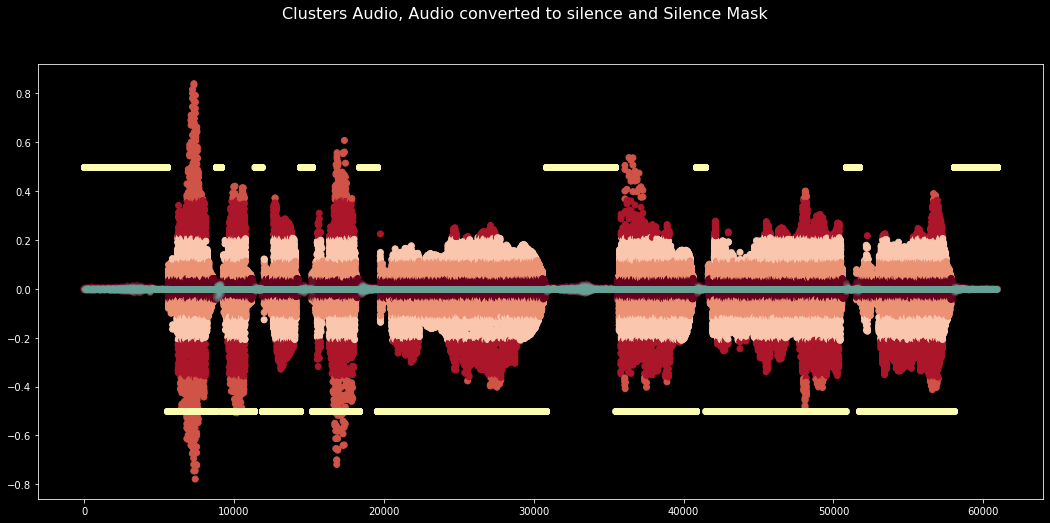

In [310]:
import matplotlib.cm as cm

x_ = np.arange(lp_silencer.audio.shape[0])
c_ = lp_silencer.kmeans.labels_
cmap = cm.get_cmap('RdBu', 12)
colors = cmap(np.arange(0,cmap.N))

fig, ax1  = plt.subplots(figsize=(18,8))
fig.suptitle('Clusters Audio, Audio converted to silence and Silence Mask', fontsize=16)
ax1.scatter(x_, lp_silencer.audio, c=colors[c_], alpha=1)
ax1.scatter(x_, lp_silencer.audio-lp_silencer.forced_silence, alpha=0.02)
ax1.scatter(x_, lp_silencer.smoothed_silence_mask.mask-0.5, alpha=0.25)
plt.show()


In [311]:
IPython.display.Audio(lp_silencer.forced_silence, rate=lp_sr)

In [315]:
IPython.display.Audio(np.concatenate(lp_word_list), rate=lp_sr)

In [317]:
IPython.display.Audio(np.concatenate(lp_padded_audio_word_list), rate=lp_sr)